## Projet APST2 Clustering: French Presidential election 2022 / 1st round (regional scale)

#### Roig Sébastien, Defossez Floran

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Pour l'ACP
from sklearn import decomposition
# Pour le modèle hierarchique
from scipy.cluster.hierarchy import dendrogram, linkage
# Pour le modèle de mélange gaussien
from sklearn.mixture import GaussianMixture

## Data

Les données peuvent êtres téléchargées sur https://www.data.gouv.fr/fr/datasets/r/027763c9-f97d-4468-b2d5-c310a1020fa7

In [52]:
data = pd.read_excel('data/resultats-par-niveau-reg-t1-france-entiere.xlsx')
data[:3]

,Code de la région,Libellé de la région,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,44,Grand Est,Complet,3862920,1008344,26.10,2854576,73.90,42255,1.09,...,Philippe,22241,0.58,0.80,M,DUPONT-AIGNAN,Nicolas,74916,1.94,2.68
1,75,Nouvelle-Aquitaine,Complet,4463041,962499,21.57,3500542,78.43,53440,1.20,...,Philippe,32597,0.73,0.95,M,DUPONT-AIGNAN,Nicolas,67645,1.52,1.98
2,84,Auvergne-Rhône-Alpes,Complet,5557535,1228490,22.10,4329045,77.90,70067,1.26,...,Philippe,30586,0.55,0.72,M,DUPONT-AIGNAN,Nicolas,98446,1.77,2.33


Cet excel est moche, il faut nommer correctement les colonnes

In [53]:
old_names = [
    'Sexe', 'Nom', 'Prénom', 'Voix',
    '% Voix/Ins', '% Voix/Exp', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
    'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
    'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
    'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
    'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
    'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
    'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49',
    'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53',
    'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57',
    'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61',
    'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65',
    'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69',
    'Unnamed: 70', 'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 73',
    'Unnamed: 74', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77',
    'Unnamed: 78', 'Unnamed: 79', 'Unnamed: 80', 'Unnamed: 81',
    'Unnamed: 82', 'Unnamed: 83', 'Unnamed: 84', 'Unnamed: 85',
    'Unnamed: 86', 'Unnamed: 87', 'Unnamed: 88'
]
candidats = [
    'arthaud', 'roussel', 'macron', 'lassalle', 'lepen', 'zemmour',
    'melenchon', 'hidalgo', 'jadot', 'pecresse', 'poutou', 'dupont_aignant'
]
labels_per_candidats = ['Sexe', 'Nom', 'Prénom', 'Voix', '%Voix/Ins', '%Voix/Exp']
new_labels = [l + '_' + c for c in candidats for l in labels_per_candidats]
dict_rename = {old_names[i]: new_labels[i] for i in range(len(new_labels))}
data.rename(columns = dict_rename, inplace=True)
columns = data.columns
data[:3]

,Code de la région,Libellé de la région,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,...,Prénom_poutou,Voix_poutou,%Voix/Ins_poutou,%Voix/Exp_poutou,Sexe_dupont_aignant,Nom_dupont_aignant,Prénom_dupont_aignant,Voix_dupont_aignant,%Voix/Ins_dupont_aignant,%Voix/Exp_dupont_aignant
0,44,Grand Est,Complet,3862920,1008344,26.10,2854576,73.90,42255,1.09,...,Philippe,22241,0.58,0.80,M,DUPONT-AIGNAN,Nicolas,74916,1.94,2.68
1,75,Nouvelle-Aquitaine,Complet,4463041,962499,21.57,3500542,78.43,53440,1.20,...,Philippe,32597,0.73,0.95,M,DUPONT-AIGNAN,Nicolas,67645,1.52,1.98
2,84,Auvergne-Rhône-Alpes,Complet,5557535,1228490,22.10,4329045,77.90,70067,1.26,...,Philippe,30586,0.55,0.72,M,DUPONT-AIGNAN,Nicolas,98446,1.77,2.33


C'est mieux

## Model hierarchique

En première apporche nous proposons de construire des clusters sur les région en utilisant un modèle hierarchique. Nous prenons en compte les poucentage de voix données à chaques candidats par rapport au voix exprimées. Il n'y a donc pas de considération sur la répatation de la population entre les régions ni sur les voix non exprimées (votes blanc, votes nuls, non votants)

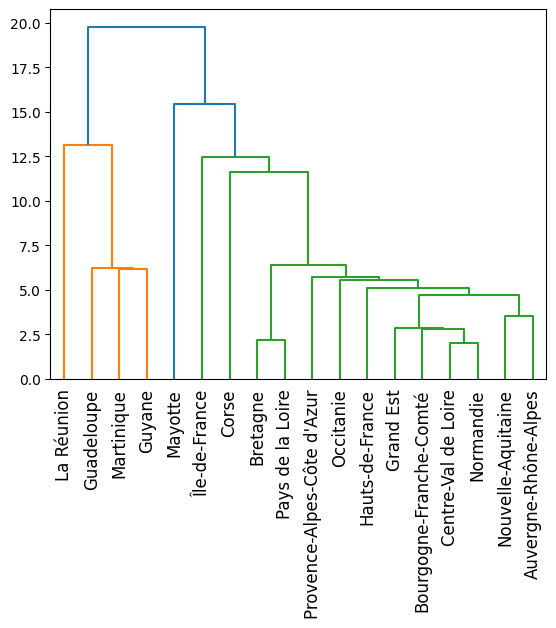

In [20]:
votes = data[['%Voix/Exp' + '_' + c for c in candidats]]
hierarchic_model = linkage(y = votes)

labels = np.array(data['Libellé de la région'])
dendrogram(hierarchic_model, labels = labels, leaf_rotation = 90)
plt.show()

On remarque un net distinction entre les territoire d'outre mer et la métropole. On observe que La Rénuion, Guadeloupe, Martinique et Guyane appartiennent à un cluster (dont les votes ont été très majoritairement en faveur du candidat Mélanchon), Mayotte seule dans son cluster et nfin les régions de la métropole.

Parmi les régions de la métropole, on apperçois que l'Ile-de-France et la Corse se détachent un peu du reste des régions. On peut aussi constater que certaines régions proches géographiquement sons aussi très proches voisin dans l'arbre, on peut noter dans ce cas la Bretagne et les Pays de la Loire ainsi que Centre-Val de Loire et Normandie.

## Gaussian Mixture Model

Nous allons utiliser un alogithme Expectation-Minimisation pour faire du clustering ici mais nous utiliserons une librairie. L'utilisation du code issue du TP est délicate pour plusieurs raisons:
- Les calcules de log-vraissemblance mènent à des valeurs extrêments faibles
- Le critère de convergence est difficile à donner
- L'algorithme est assez instable

Commençons par 3 clusters et voyons si nous obtenons les mêmes résultats qu'avec le modèle hierarchique

In [23]:
gaussian_mixture_model = GaussianMixture(n_components=3).fit(votes)
clusters = gaussian_mixture_model.predict(votes)

Pour afficher nos résultats, nous allons réaliser une analyse en composante principale pour représenter les votes des régions dans un espace orthogonale qui maximise la variance

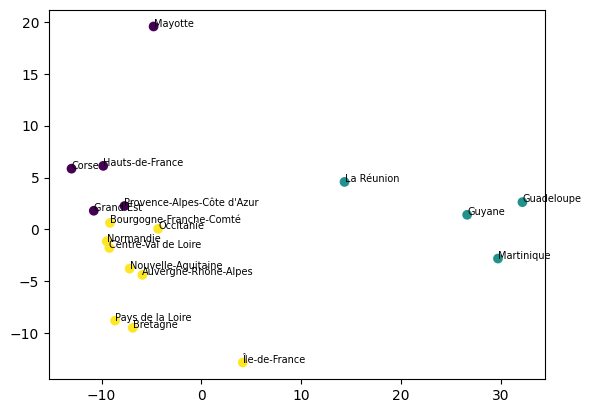

In [35]:
pca = decomposition.PCA(n_components=2)

plt.scatter(*pca.fit_transform(votes).T, c=clusters)
for i,(x,y) in enumerate(pca.fit_transform(votes)):
    plt.text(x,y,labels[i], fontsize=7)
plt.show()

On peux faire les mêmes constats que précédement concernant les régions d'outre mers avec Mayotte à part. Toutefois, l'Ile de France et la Corse n'appartiennent pas au même cluster et sont même très éloignées ici.

Tentons de réaliser de nouveau le clustering mais cette fois uniquement sur les région de la métropole.

In [45]:

metropole = [
    'Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
    'Île-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
    'Pays de la Loire', "Provence-Alpes-Côte d'Azur"
]
votes_metropole = votes[:-6]

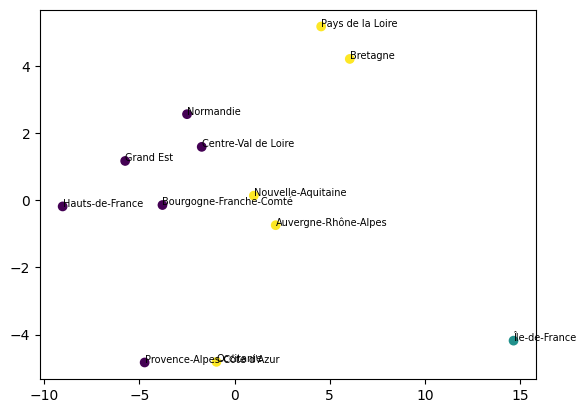

In [51]:
gaussian_mixture_model_metropole = GaussianMixture(n_components=3).fit(votes_metropole)
clusters_metropole = gaussian_mixture_model_metropole.predict(votes_metropole)

pca_metropole = decomposition.PCA(n_components=2)

plt.scatter(*pca_metropole.fit_transform(votes_metropole).T, c=clusters_metropole)
for i,(x,y) in enumerate(pca_metropole.fit_transform(votes_metropole)):
    plt.text(x,y,metropole[i], fontsize=7)
plt.show()

Toujours en prenant 3 clusters, on voit l'Ile de France est seule, il semble difficile de conclure autre chose pour les autres région. On peut noter que, dans l'analyse ACP, les régions proches géographiquement sont encore une fois proche sur la figure, en particulier la Bretagne et les Pays de la Loire ainsi que Centre-Val de Loire et Normandie comme pour le modèle hierarchique.